# Seurat notes

These are my notes from the introductory vignette provided for the Seurat package. The tutorial instructs how to analyse data from cellranger from QC to clustering/DE analysis. It uses a publically available dataset of 2700 Peripheral Blood Mononuclear Cells (PBMC) from 10X Genomics. It can be found here:

https://satijalab.org/seurat/articles/pbmc3k_tutorial.html

In [27]:
library(repr)
options(repr.plot.width = 12, repr.plot.height = 8)

suppressMessages(library(dplyr))
suppressMessages(library(Seurat))
suppressMessages(library(patchwork))

## Make Seurat Object

First, we need to load the PBMC dataset. The `Read10X` function reads output of cellranger pipeline, returning a unique molecular identified (UMI) count matrix where the columns are cells and rows are molecules.

In [2]:
pbmc.data <- Read10X(data.dir = 'datasets/pbmc3k/hg19')

We then need to initialize the Seurat object with the raw (non-normalized data). This will contain the count matrix in as well as later analyses e.g. PCA and clustering. We do this with the `CreateSeuratObject` function which has these parameters:
- `counts` - data (unnormalised)
- `project` - name
- `min.cells` - include features detected in at least this many cells
- `min.features` - include cells with at least this many features

In [3]:
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

## Pre-processing

### QC and selecting cells

First, we need to perform quality control on our data. Here are a few commonly used QC metrics:
- Number of unique genes detected in each cell (this is calculated when creating a Seurat object and is found in the object metadata)
    - Low-quality cells or empty droplets - very few genes
    - Cell doublets or multiplets - high gene counts
- Total number of molecules detected within a cell (correlates strongly with unique genes)
- Percentage of reads that map to the mitochondrial genome (all genes starting with 'MT-') which indicate low-quality / dying cells. Mitochondrial QC metrics can be calculated with the `PercentageFeatureSet()` function (calculates the percentage of counts originating from a set of features e.g. MT genes)

More about this here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4758103/

In [4]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [5]:
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898


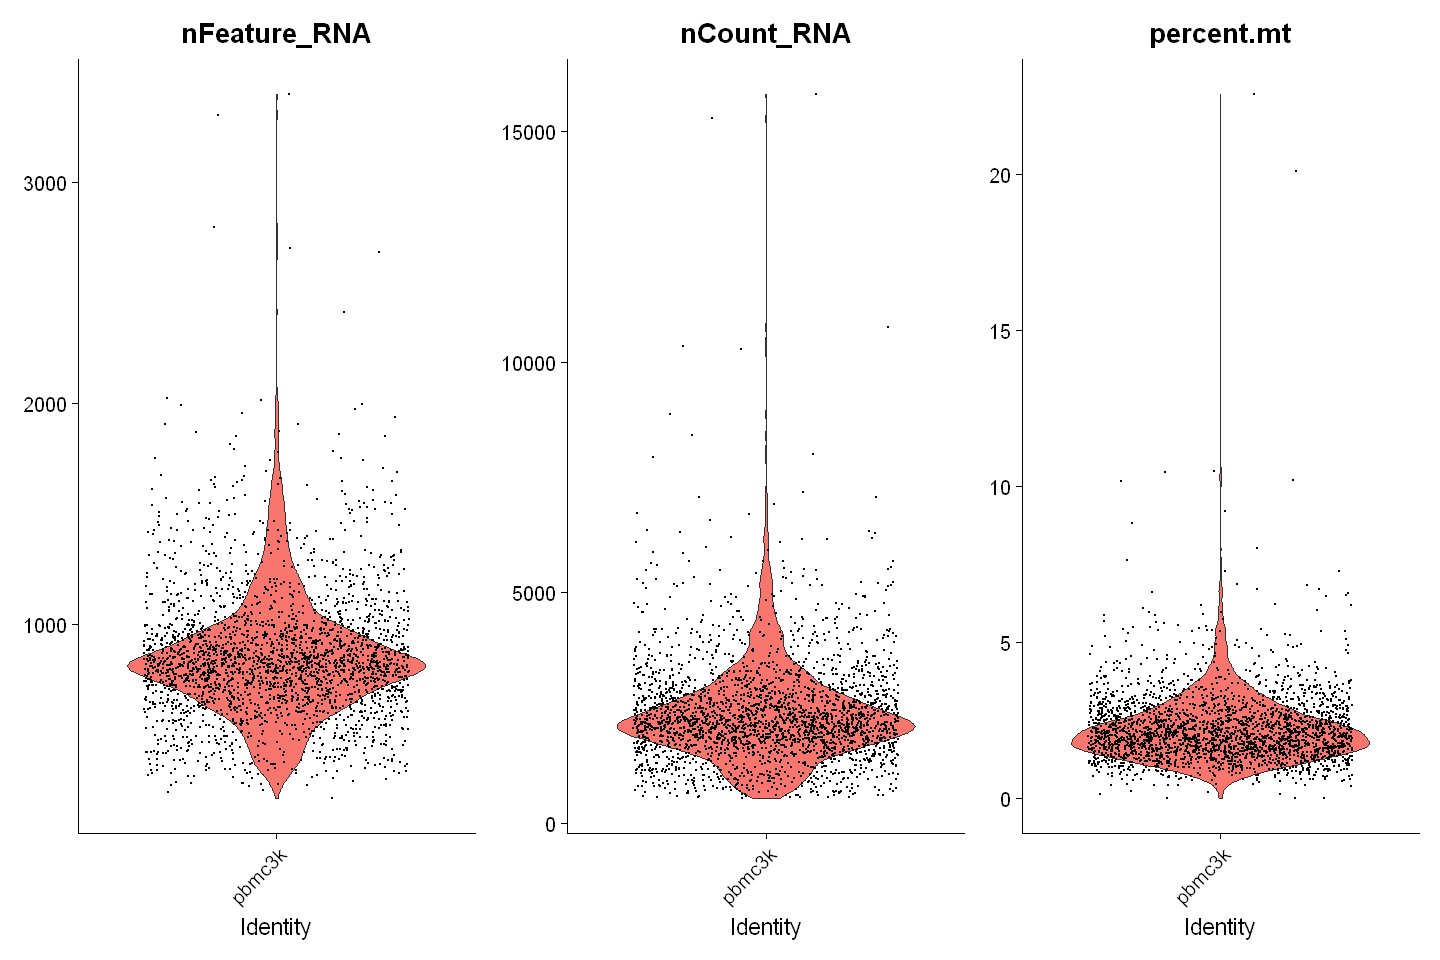

In [6]:
# We can visualise QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

You can use `FeatureScatter` to visualize feature-feature relationships. It can be used for anything calculated by the object like columns in object metadata, PC scores etc.

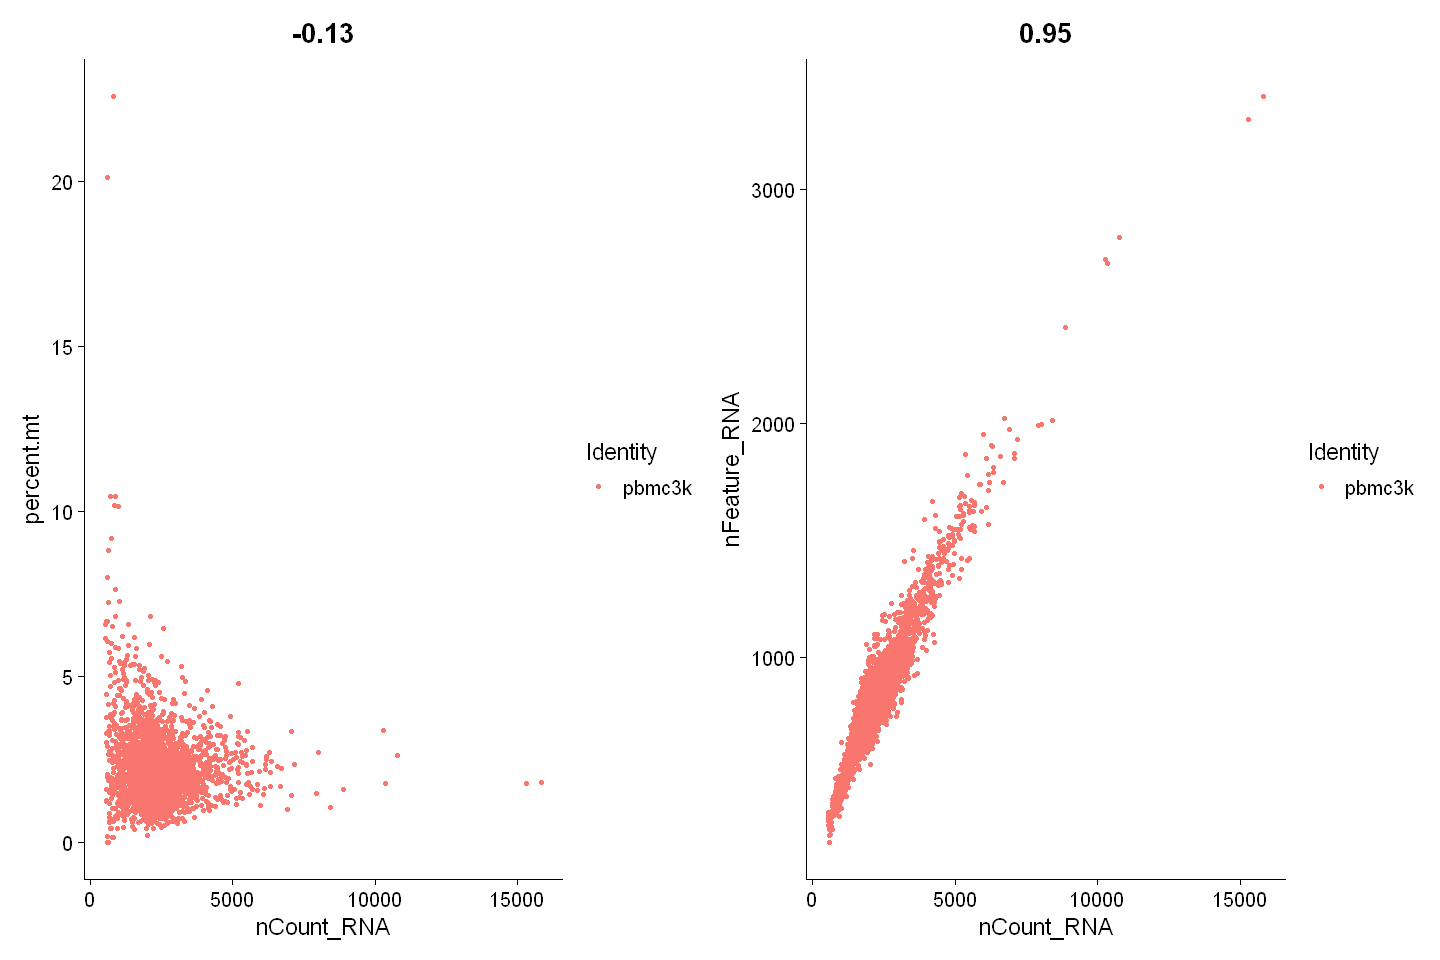

In [7]:
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

**Filter cells**

We can then use our QC metrics to filter the cells. Lets filter ours:
- Unique feature counts over 2,500 or less than 200
- Over 5% mitochondrial count

In [8]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

### Normalising

Now we have removed the cells we don't want, we need to normalise the data. The default method for the `NormalizeData()` function is a global-scaling normalisation method 'LogNormalise' which:
1. Normalises feature expression measurements for each cell by the total expression
2. Multiplies this by a scale factor (10,000 by default) 
3. Log-transforms the result

In [9]:
pbmc <- NormalizeData(pbmc)

# These are some parameters:
# pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

In [10]:
# The results are stored in the metadata

norm_value <- pbmc[["RNA"]]@data
norm_value[1:5, 1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
              AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1
AL627309.1                   .                .                .
AP006222.2                   .                .                .
RP11-206L10.2                .                .                .
RP11-206L10.9                .                .                .
LINC00115                    .                .                .
              AAACCGTGCTTCCG-1 AAACCGTGTATGCG-1
AL627309.1                   .                .
AP006222.2                   .                .
RP11-206L10.2                .                .
RP11-206L10.9                .                .
LINC00115                    .                .

### Feature Identification/Selection

scRNA-seq data can have thousands of genes. In order to analyse the data, we need to identify genes that are expressed highly in some cells and less in others (i.e. highly variable features). Seurat does this by directly modelling the mean-variance relationship inherent in single-cell data. To do this, use the `FindVariableFeatures()` function. This returns 2000 features per dataset by default. More on this here: 

https://linkinghub.elsevier.com/retrieve/pii/S0092867419305598

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 1 rows containing missing values (geom_point)."


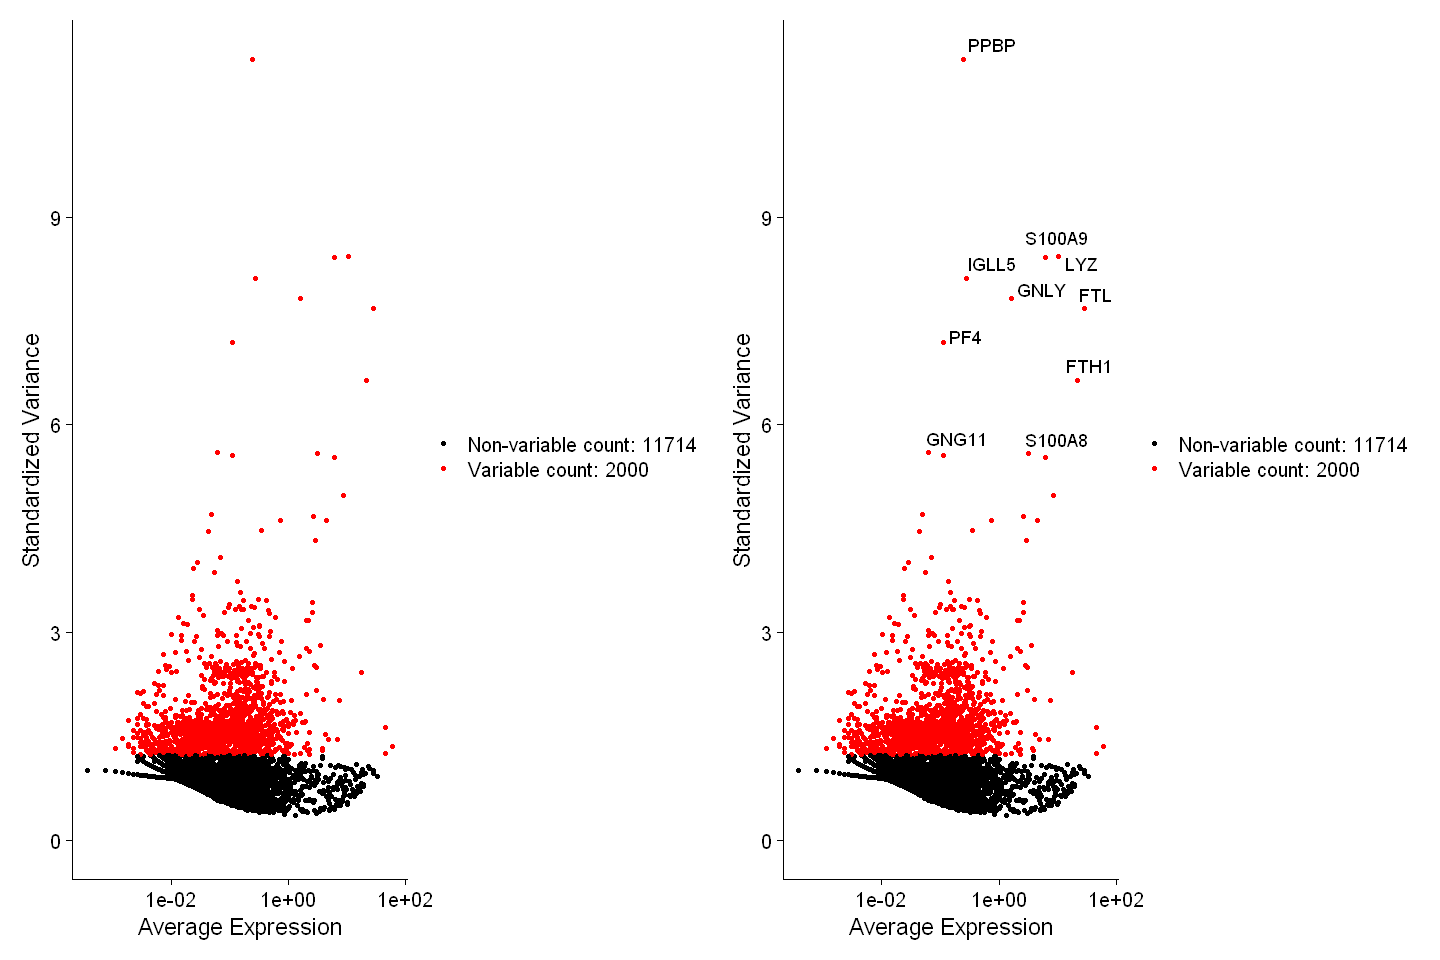

In [11]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
options(repr.plot.width = 12)
plot1 + plot2

### Scaling

Next, we need to scale our data using the `ScaleData()` function. This is a linear transformation that is done before dimensional reduction that:
- Shifts the expression of each gene so that the mean expression across cells is 0
- Scales the expression of eah gene so that the variance across cells is 1 - this gives equal weight to highly expressed genes do not dominate downstream analyses

In [12]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



In [14]:
# Results are stored in the metadata

scaled_values <- pbmc[["RNA"]]@scale.data
scaled_values[1:5, 1:5]

,AAACATACAACCAC-1,AAACATTGAGCTAC-1,AAACATTGATCAGC-1,AAACCGTGCTTCCG-1,AAACCGTGTATGCG-1
AL627309.1,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316
AP006222.2,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571
RP11-206L10.2,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819
RP11-206L10.9,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562
LINC00115,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981


This also has a parameter, `vars.to.regress`, which lets you remove other sources of noise like cell cycle stage or mitochondirual contamination.

In [16]:
pbmc <- ScaleData(pbmc, vars.to.regress = "percent.mt")

Regressing out percent.mt

Centering and scaling data matrix



This can also be done using the `SCTransform()` function. A different tutorial covers this.

## Dimentional reduction

### Linear (PCA)

Now we need to reduce the dimentionality of the data. By default, only the 2000 variable features we identified are used as an input, but can be changed using `features` argument if the `RunPCA()` function.

In [17]:
pbmc <- suppressMessages(RunPCA(pbmc, features = VariableFeatures(object = pbmc)))

In [19]:
# The PCs are stored in the metadata
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMA, GZMB 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPA1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, S100A8, IL32 
PC_ 5 
Positive:  GZMB, FGFBP2, S100A8, NKG7, GNLY 
Negative:  LTB, IL7R, CKB, MS4A7, RP11-290F20.3 


We can visualise the top genes associated with reduction components using the `VizDimLoadings()` function.

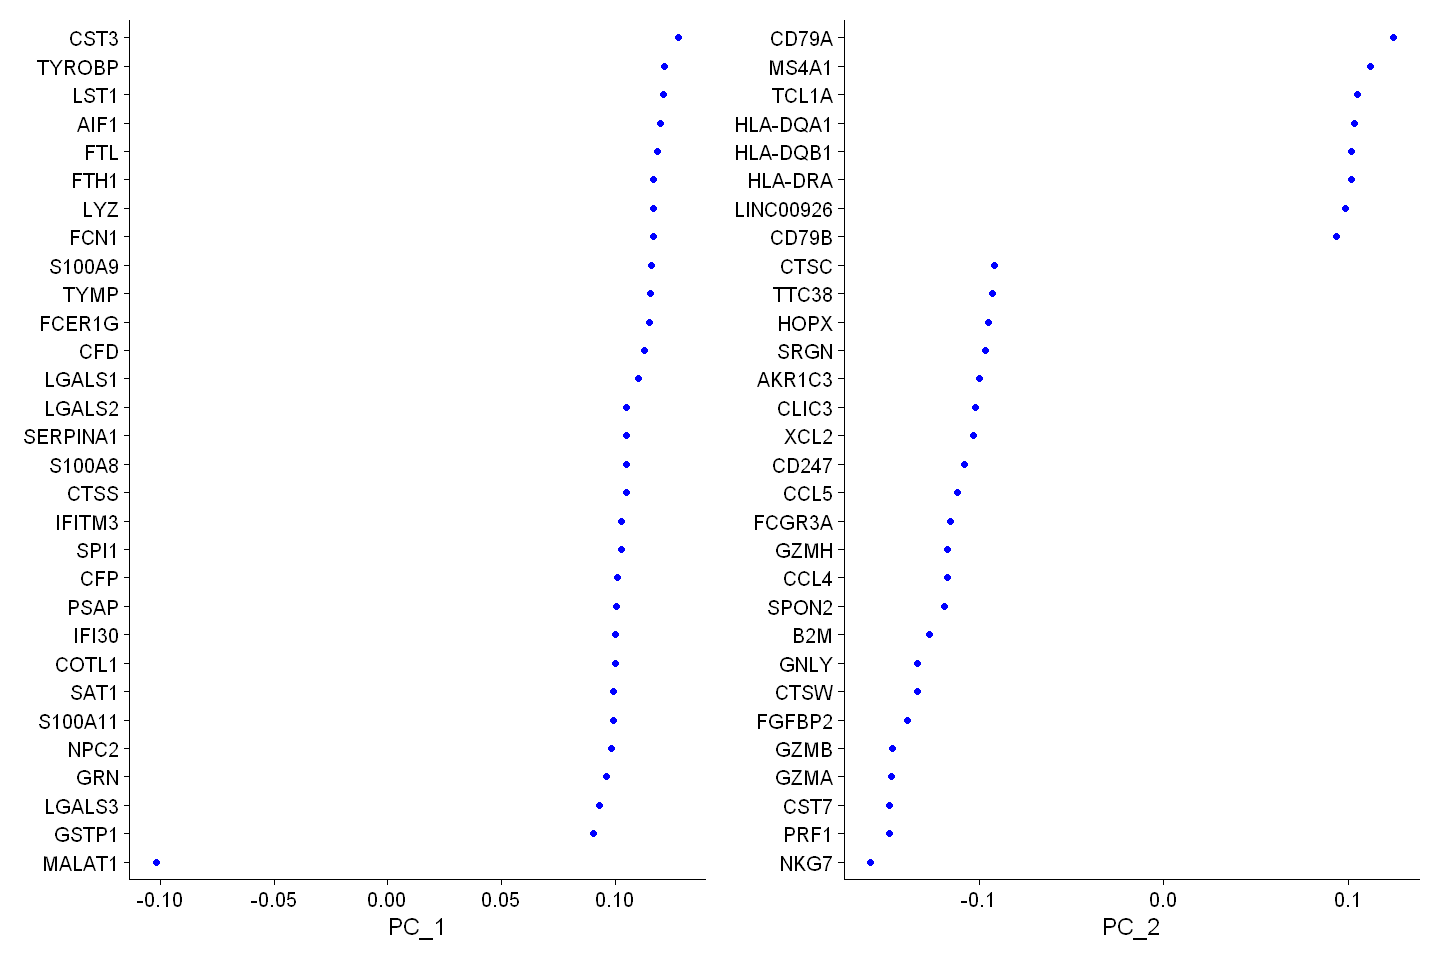

In [22]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

We can ise the `DimPlot()` function to view out PCA plot.

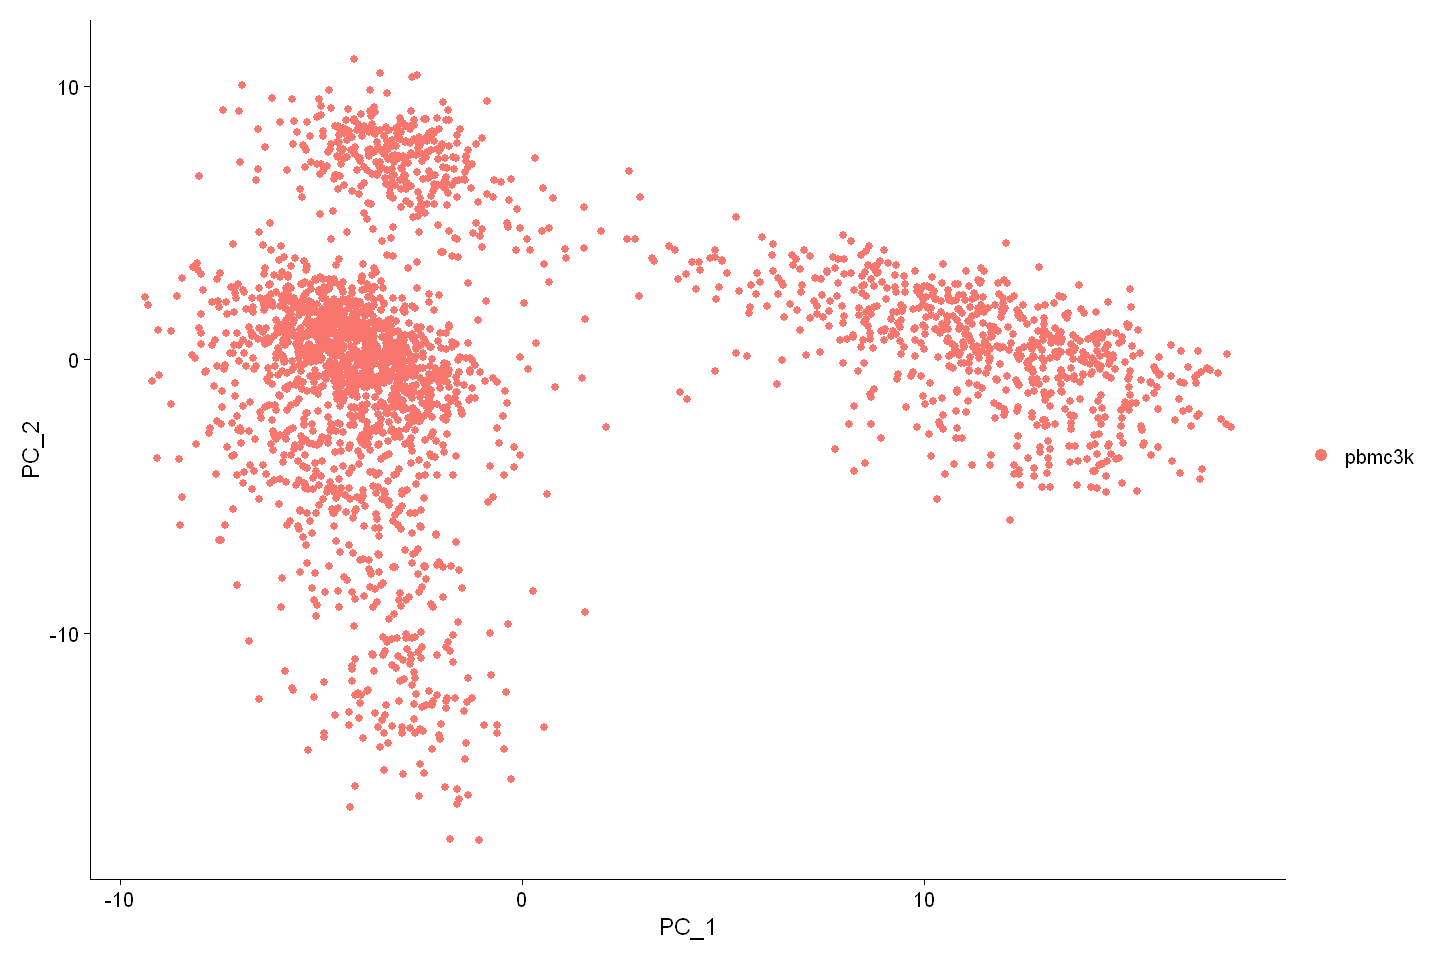

In [23]:
DimPlot(pbmc, reduction = "pca", pt.size = 2)

Plotting a heatmap, using the `DimHeatmap()` function, can be used to identify primary sources of heterogeneity in a dataset. This is useful for deciding which PCs to include for downstream analyses. Both the cells and features are ordered by their PCA scores. For large datasets, you can set the `cells` parameter to a number to include the most extreme cells on both ends of the spectrum.

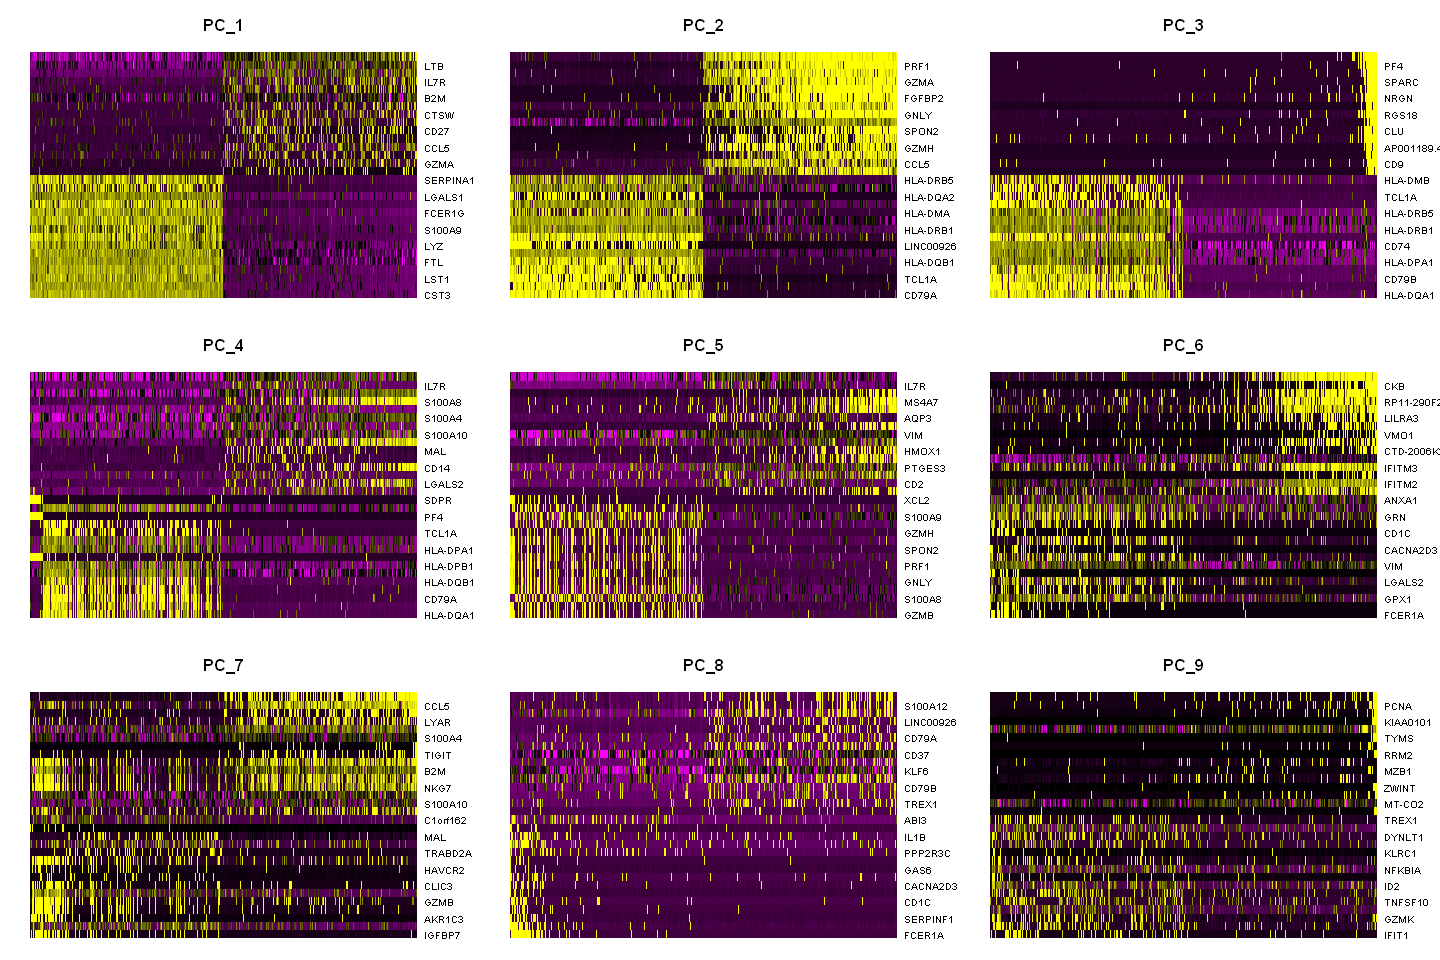

In [24]:
DimHeatmap(pbmc, dims = 1:9, cells = 500, balanced = TRUE)
options(repr.plot.height = 20)

#### Determining dimentionality

Seurat clusters cells based on their PCA scores, but we need to know how many PCs to choose. This can be done using the `JackStrawPlot()` function. It selects 1% of the data at random, then runs a PCA. This is repeated to construct a 'null distributiuon' of feature scores. It then uses this to identify significant PCs that have many low p-value features.

In [25]:
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

We can then visualise distribution of p-values for each PC using the `JackStrawPlot()` function which plots the distribution of p-values for each PC. Significant PCs will have a curve above the line.

Warning message:
"Removed 23438 rows containing missing values (geom_point)."


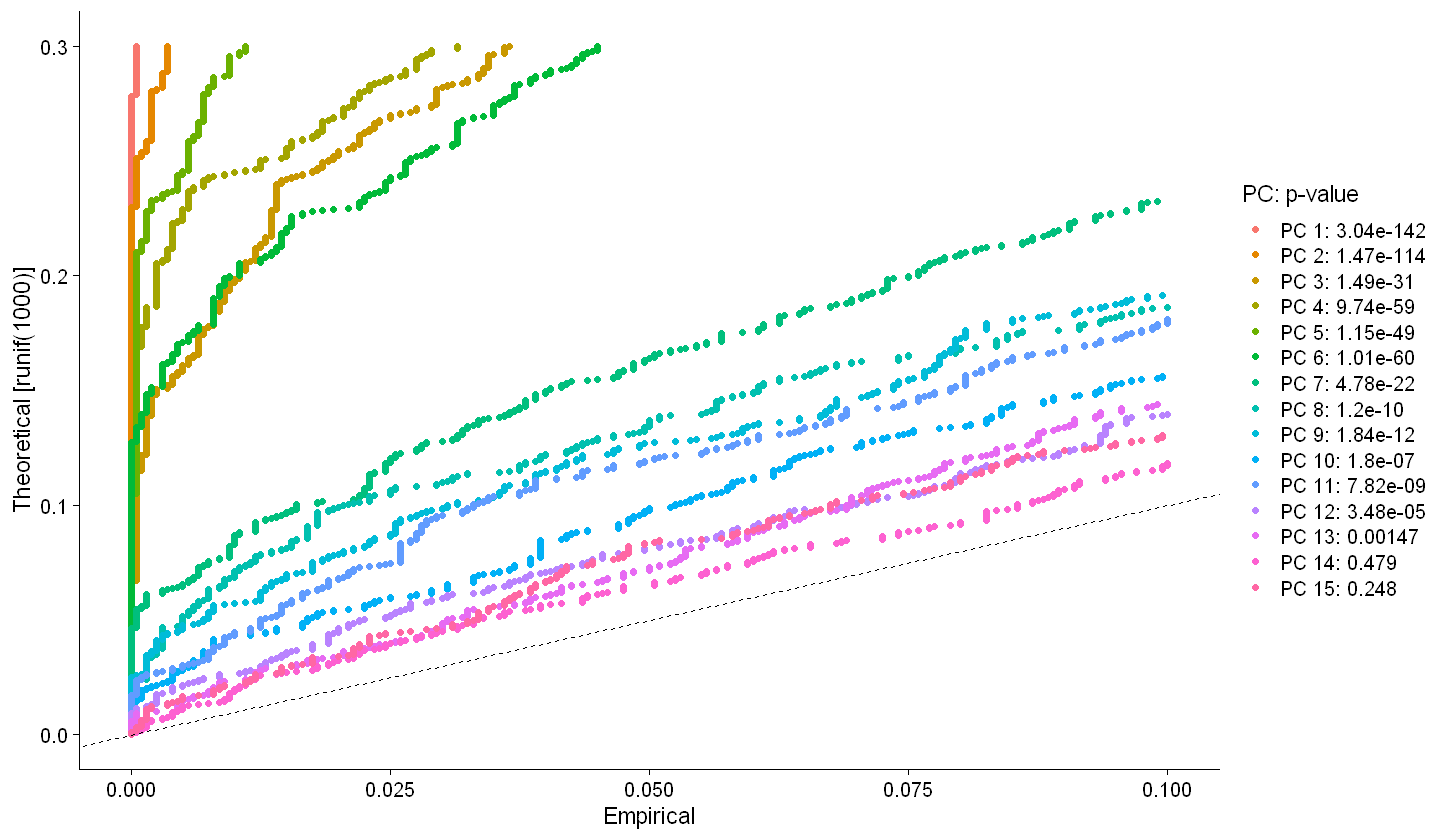

In [29]:
JackStrawPlot(pbmc, dims = 1:15)

# You can see a drop-off in significance after the first 10-12 PCs.

As this can take a long time, the `ElbowPlot()` function can be used instead. This ranks principle components based on the percentage of variance explained by each one.

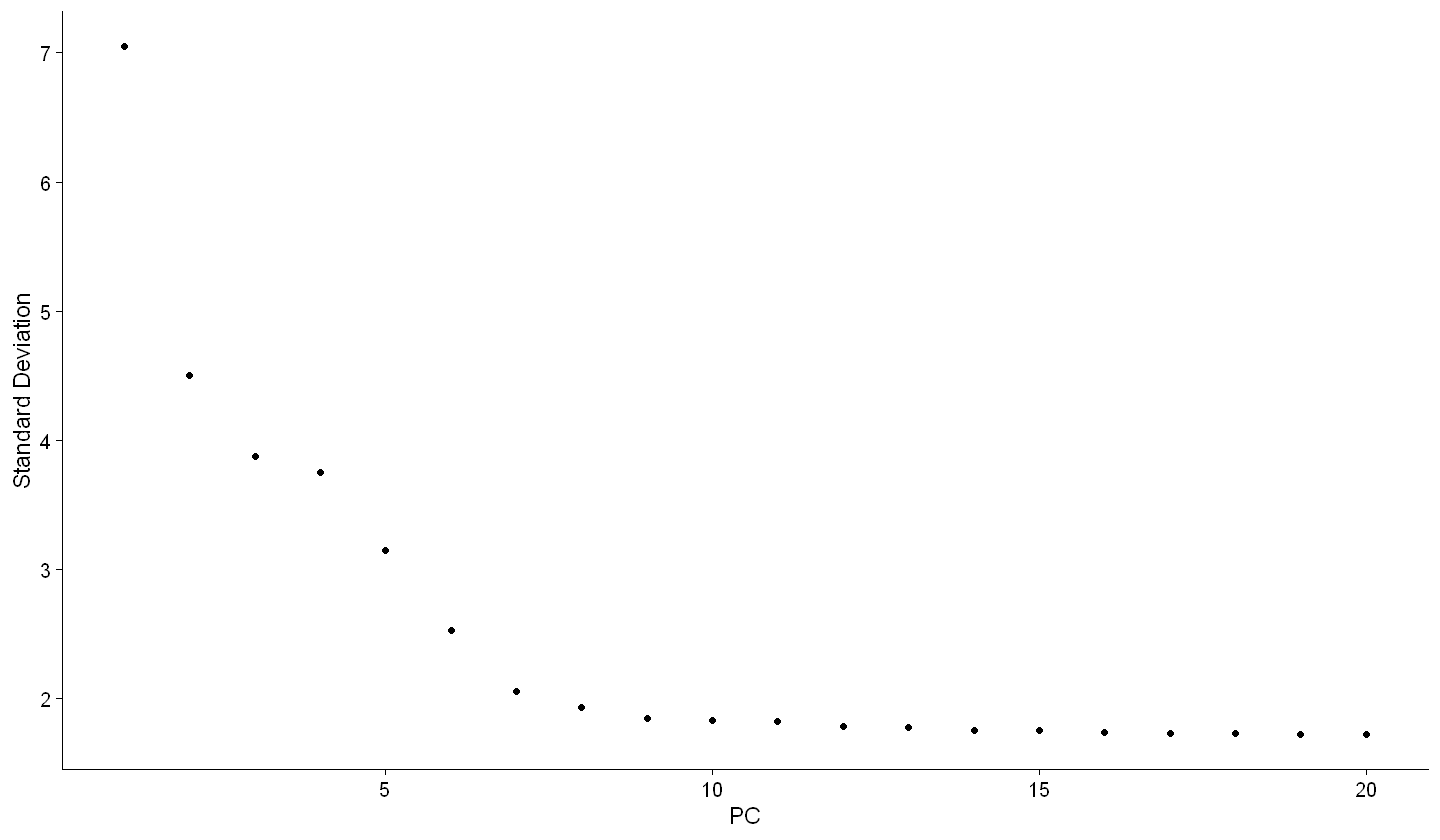

In [31]:
ElbowPlot(pbmc)

# This shows the majority of the variation is explained by the first 10 PCs

Before committing to a number of PCs, repeat downstream analyses using different numbers of PCs and err on the side of more.

## Clustering

In [22]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95843

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8722
Number of communities: 9
Elapsed time: 0 seconds


In [23]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               1                3                1                2 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

## Non-linear dimentional reduction (UMAP/tSNE)

The goal of these algorithms is to learn the underlying manifold of the data in order to place similar cells together in low-dimentional space. Cells within the graph-based ludters determined above should co-localise on these dimention reduction plots. Input the same PCs as in the clustering analysis.

In [24]:
pbmc <- RunUMAP(pbmc, dims = 1:10)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
17:19:21 UMAP embedding parameters a = 0.9922 b = 1.112

17:19:21 Read 2638 rows and found 10 numeric columns

17:19:21 Using Annoy for neighbor search, n_neighbors = 30

17:19:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:19:22 Writing NN index file to temp file C:\Users\Emily\AppData\Local\Temp\RtmpITv4uk\file21c187e3df2

17:19:22 Searching Annoy index using 1 thread, search_k = 3000

17:19:22 Annoy recall = 100%

17:19:22 Commencing smooth kNN distance calibration using 1 threa

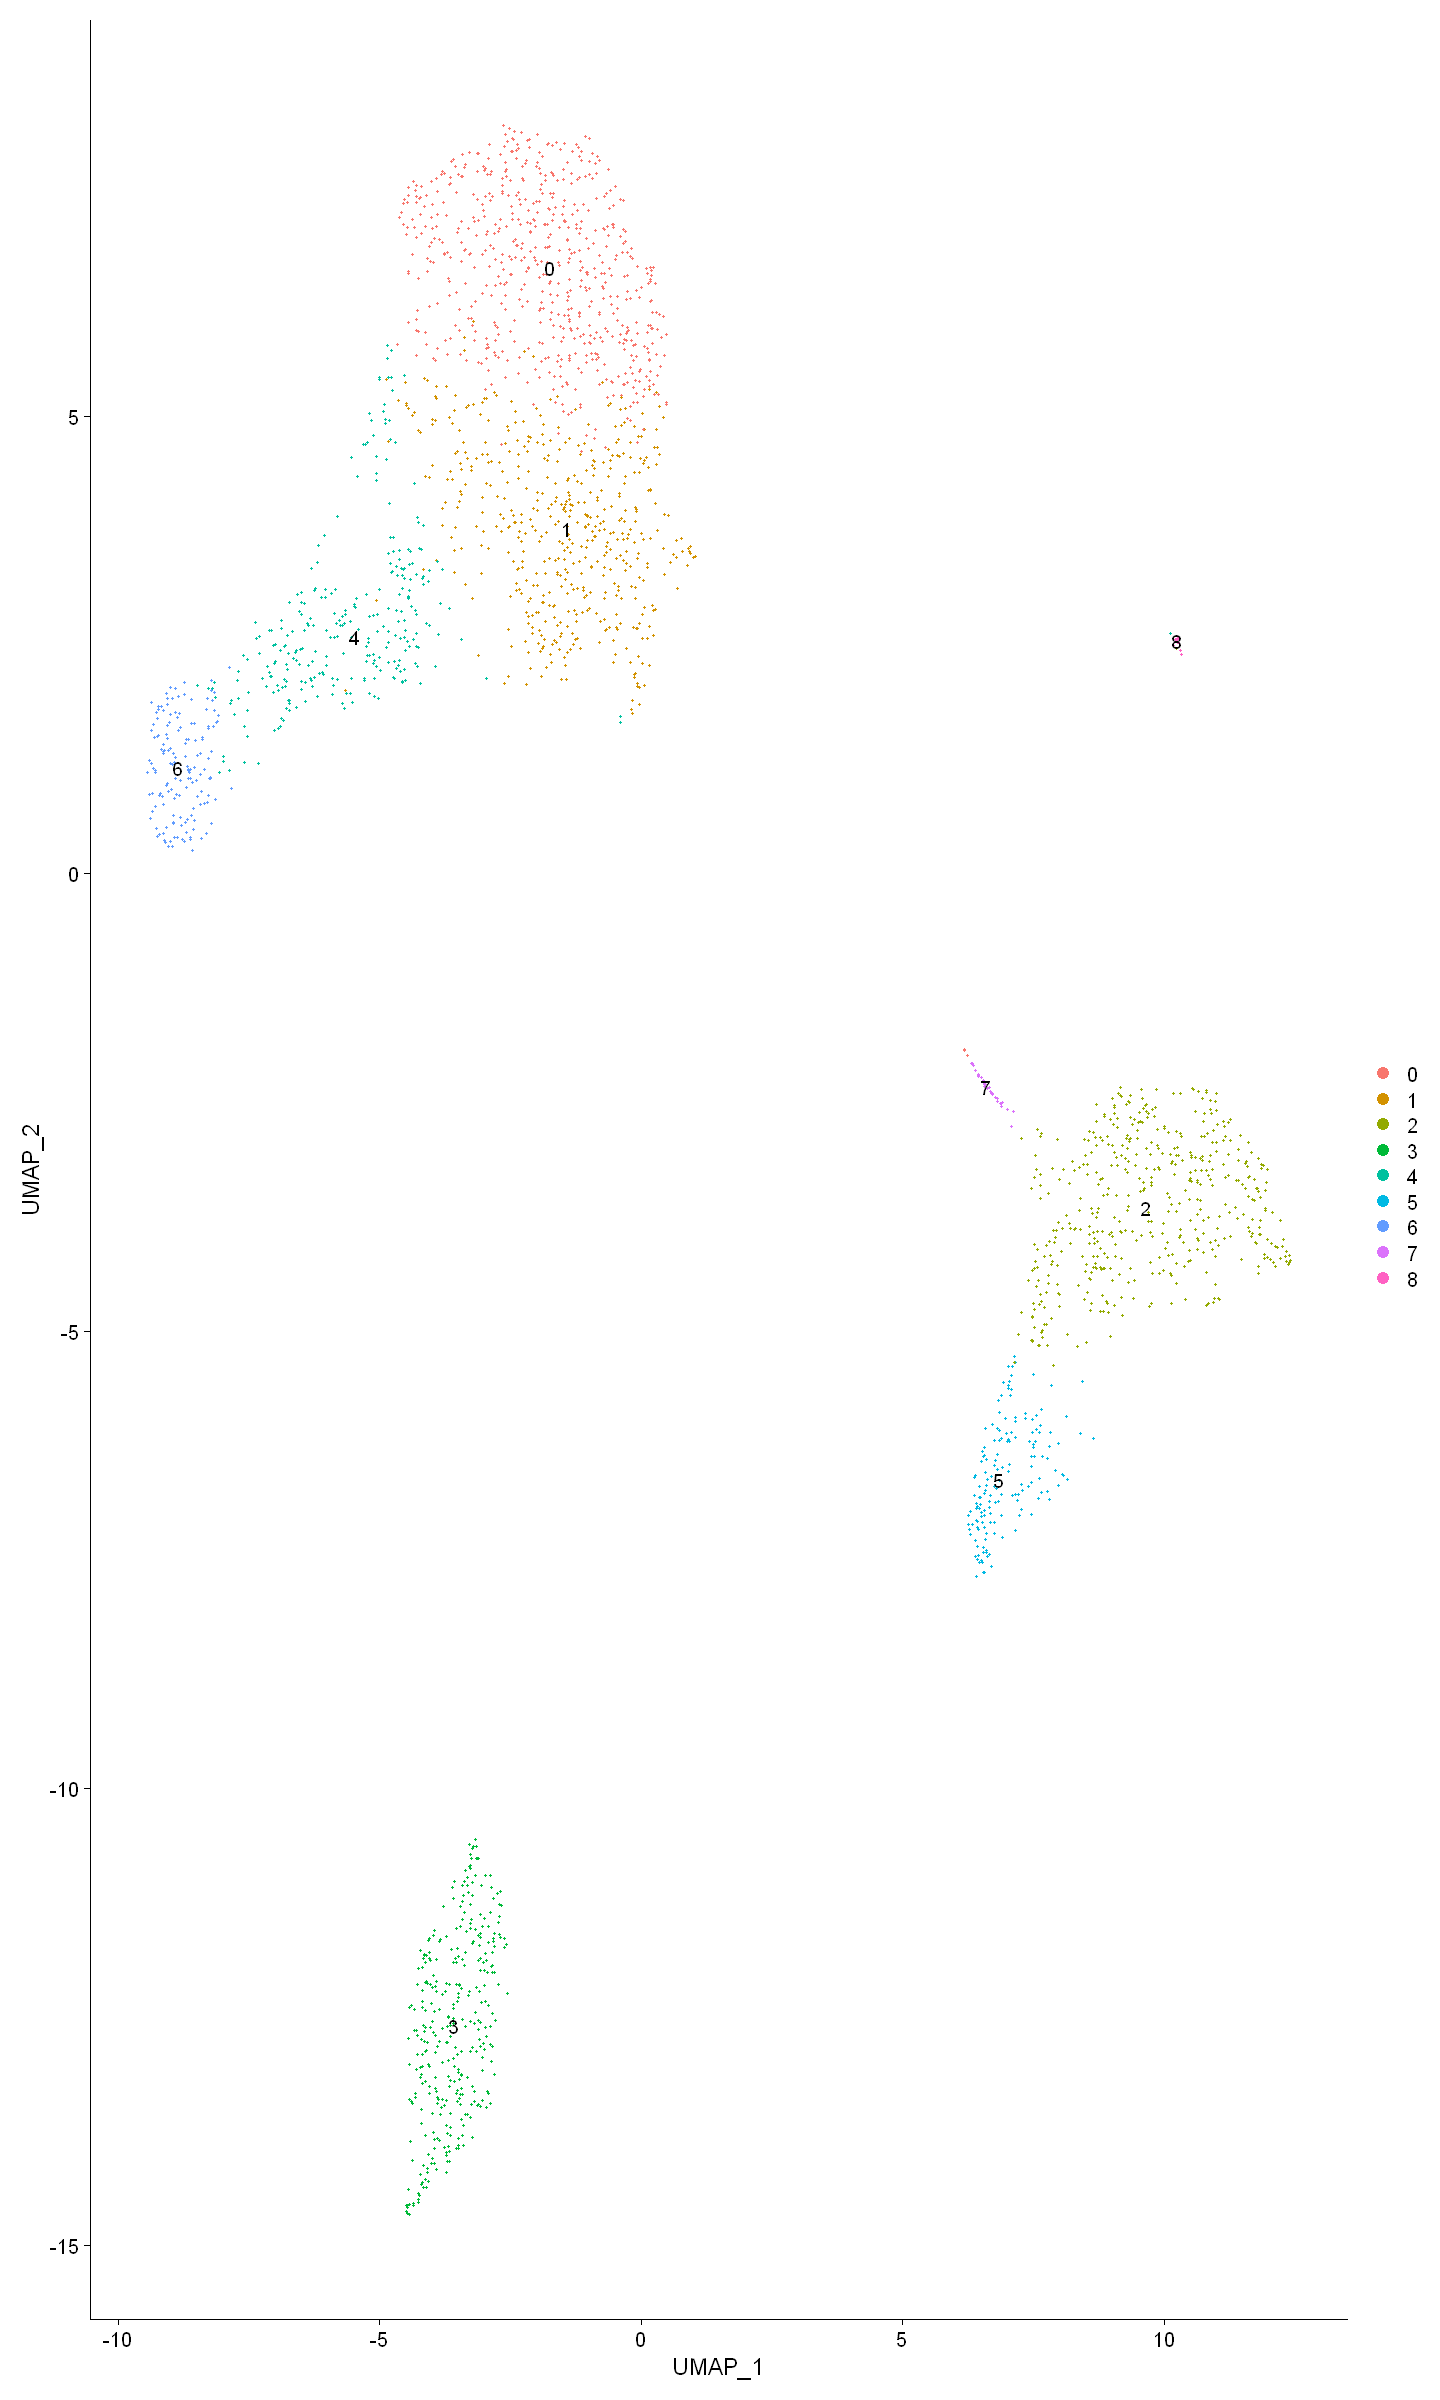

In [25]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(pbmc, reduction = "umap", label = TRUE)

### Differentially expressed features (cluster biomarkers)

Identifies positive and negative markers of a single clusters compared to other cells. This is automatic for all clusters, but can be done for different clusters or cells.

The `min.pct` argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the `thresh.test` argument requires a feature to be differentially expressed (on average) by some amount between the two groups. You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of features that are unlikely to be highly discriminatory. As another option to speed up these computations, `max.cells.per.ident` can be set. This will downsample each identity class to have no more cells than whatever this is set to. While there is generally going to be a loss in power, the speed increases can be significant and the most highly differentially expressed features will likely still rise to the top.

In [26]:
# find all markers of cluster 2
cluster2.markers <- FindMarkers(pbmc, ident.1 = 2, min.pct = 0.25)
head(cluster2.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A9,0.000000e+00,5.570063,0.996,0.215,0.000000e+00
S100A8,0.000000e+00,5.477394,0.975,0.121,0.000000e+00
FCN1,0.000000e+00,3.394219,0.952,0.151,0.000000e+00
LGALS2,0.000000e+00,3.800484,0.908,0.059,0.000000e+00
CD14,2.856582e-294,2.815626,0.667,0.028,3.917516e-290


- avg_logFC: log fold-chage of the average expression between the two groups. Positive values indicate that the gene is more highly expressed in the first group
- pct.1: The percentage of cells where the gene is detected in the first group
- pct.2: The percentage of cells where the gene is detected in the second group
- p_val_adj: Adjusted p-value, based on bonferroni correction using all genes in the dataset

In [27]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,1.503232e-201,4.272769,0.975,0.038,2.061532e-197
CFD,1.113563e-190,3.421544,0.938,0.036,1.527140e-186
IFITM3,1.609194e-190,3.870255,0.975,0.049,2.206849e-186
CD68,1.649886e-185,3.012542,0.926,0.036,2.262654e-181
RP11-290F20.3,1.408433e-180,2.716446,0.840,0.017,1.931525e-176


In [28]:
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.953049e-92,1.390891,0.464,0.109,2.678412e-88,0,CCR7
2.476123e-35,1.163925,0.263,0.082,3.395754e-31,0,LDLRAP1
7.690348e-92,1.280391,0.977,0.638,1.054654e-87,1,LTB
7.963064e-102,1.259050,0.949,0.456,1.092055e-97,1,IL32
0.000000e+00,5.570063,0.996,0.215,0.000000e+00,2,S100A9
0.000000e+00,5.477394,0.975,0.121,0.000000e+00,2,S100A8
0.000000e+00,4.310172,0.936,0.041,0.000000e+00,3,CD79A
9.481783e-271,3.591579,0.622,0.022,1.300332e-266,3,TCL1A
2.236620e-200,3.102183,0.979,0.234,3.067300e-196,4,CCL5


`test.use` argument dentotes which test to use e.g. t-test

In [29]:
cluster0.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "t", only.pos = TRUE)
head(cluster0.markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPS27,1.113918e-180,0.7374452,0.998,0.992,1.527627e-176
RPS12,3.073724e-177,0.7213193,1.000,0.991,4.215305e-173
RPS6,6.162562e-176,0.7018841,1.000,0.995,8.451337e-172
RPS25,1.874091e-151,0.7514558,0.998,0.975,2.570128e-147
RPS14,8.668378e-150,0.6290492,1.000,0.994,1.188781e-145
RPL32,5.803908e-145,0.6345197,0.998,0.995,7.959479e-141


**Visualising marker expression**

`VlnPlot()` shows the expression probability distributions across clusters and `FeaturePlot()` visualises expression on tSNE or PCA plot. Other methods are `RidgePlot()`, `CellScatter()` and `DotPlot`.

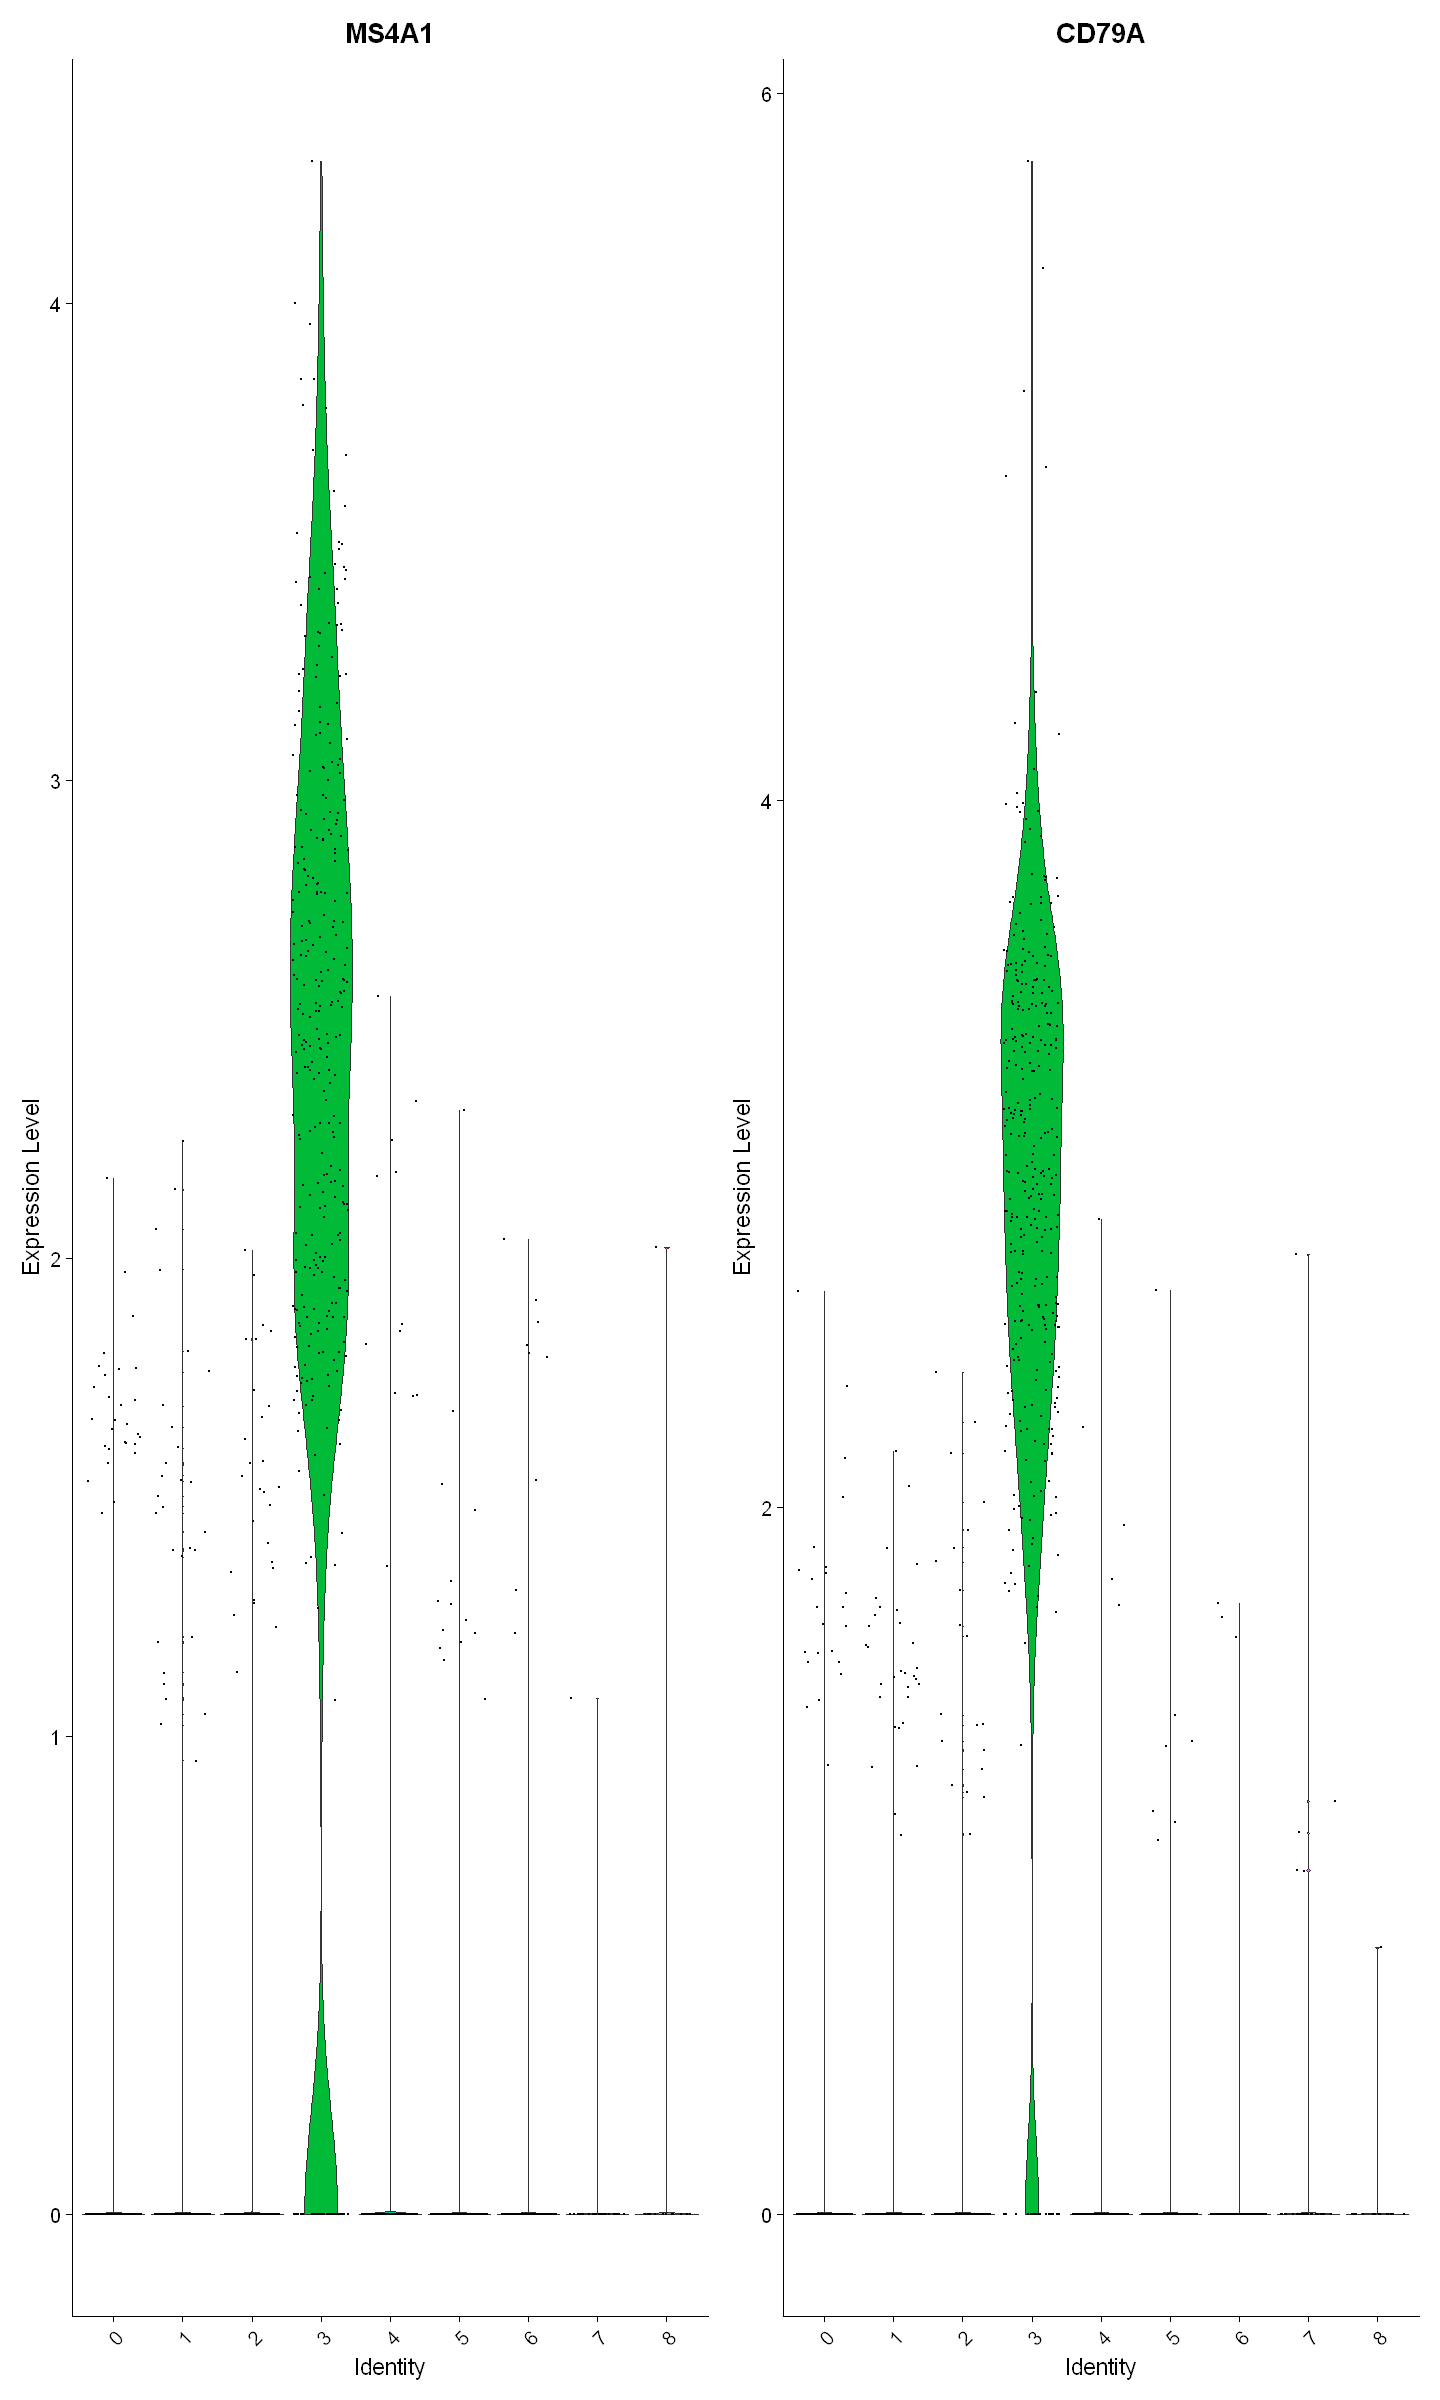

In [30]:
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

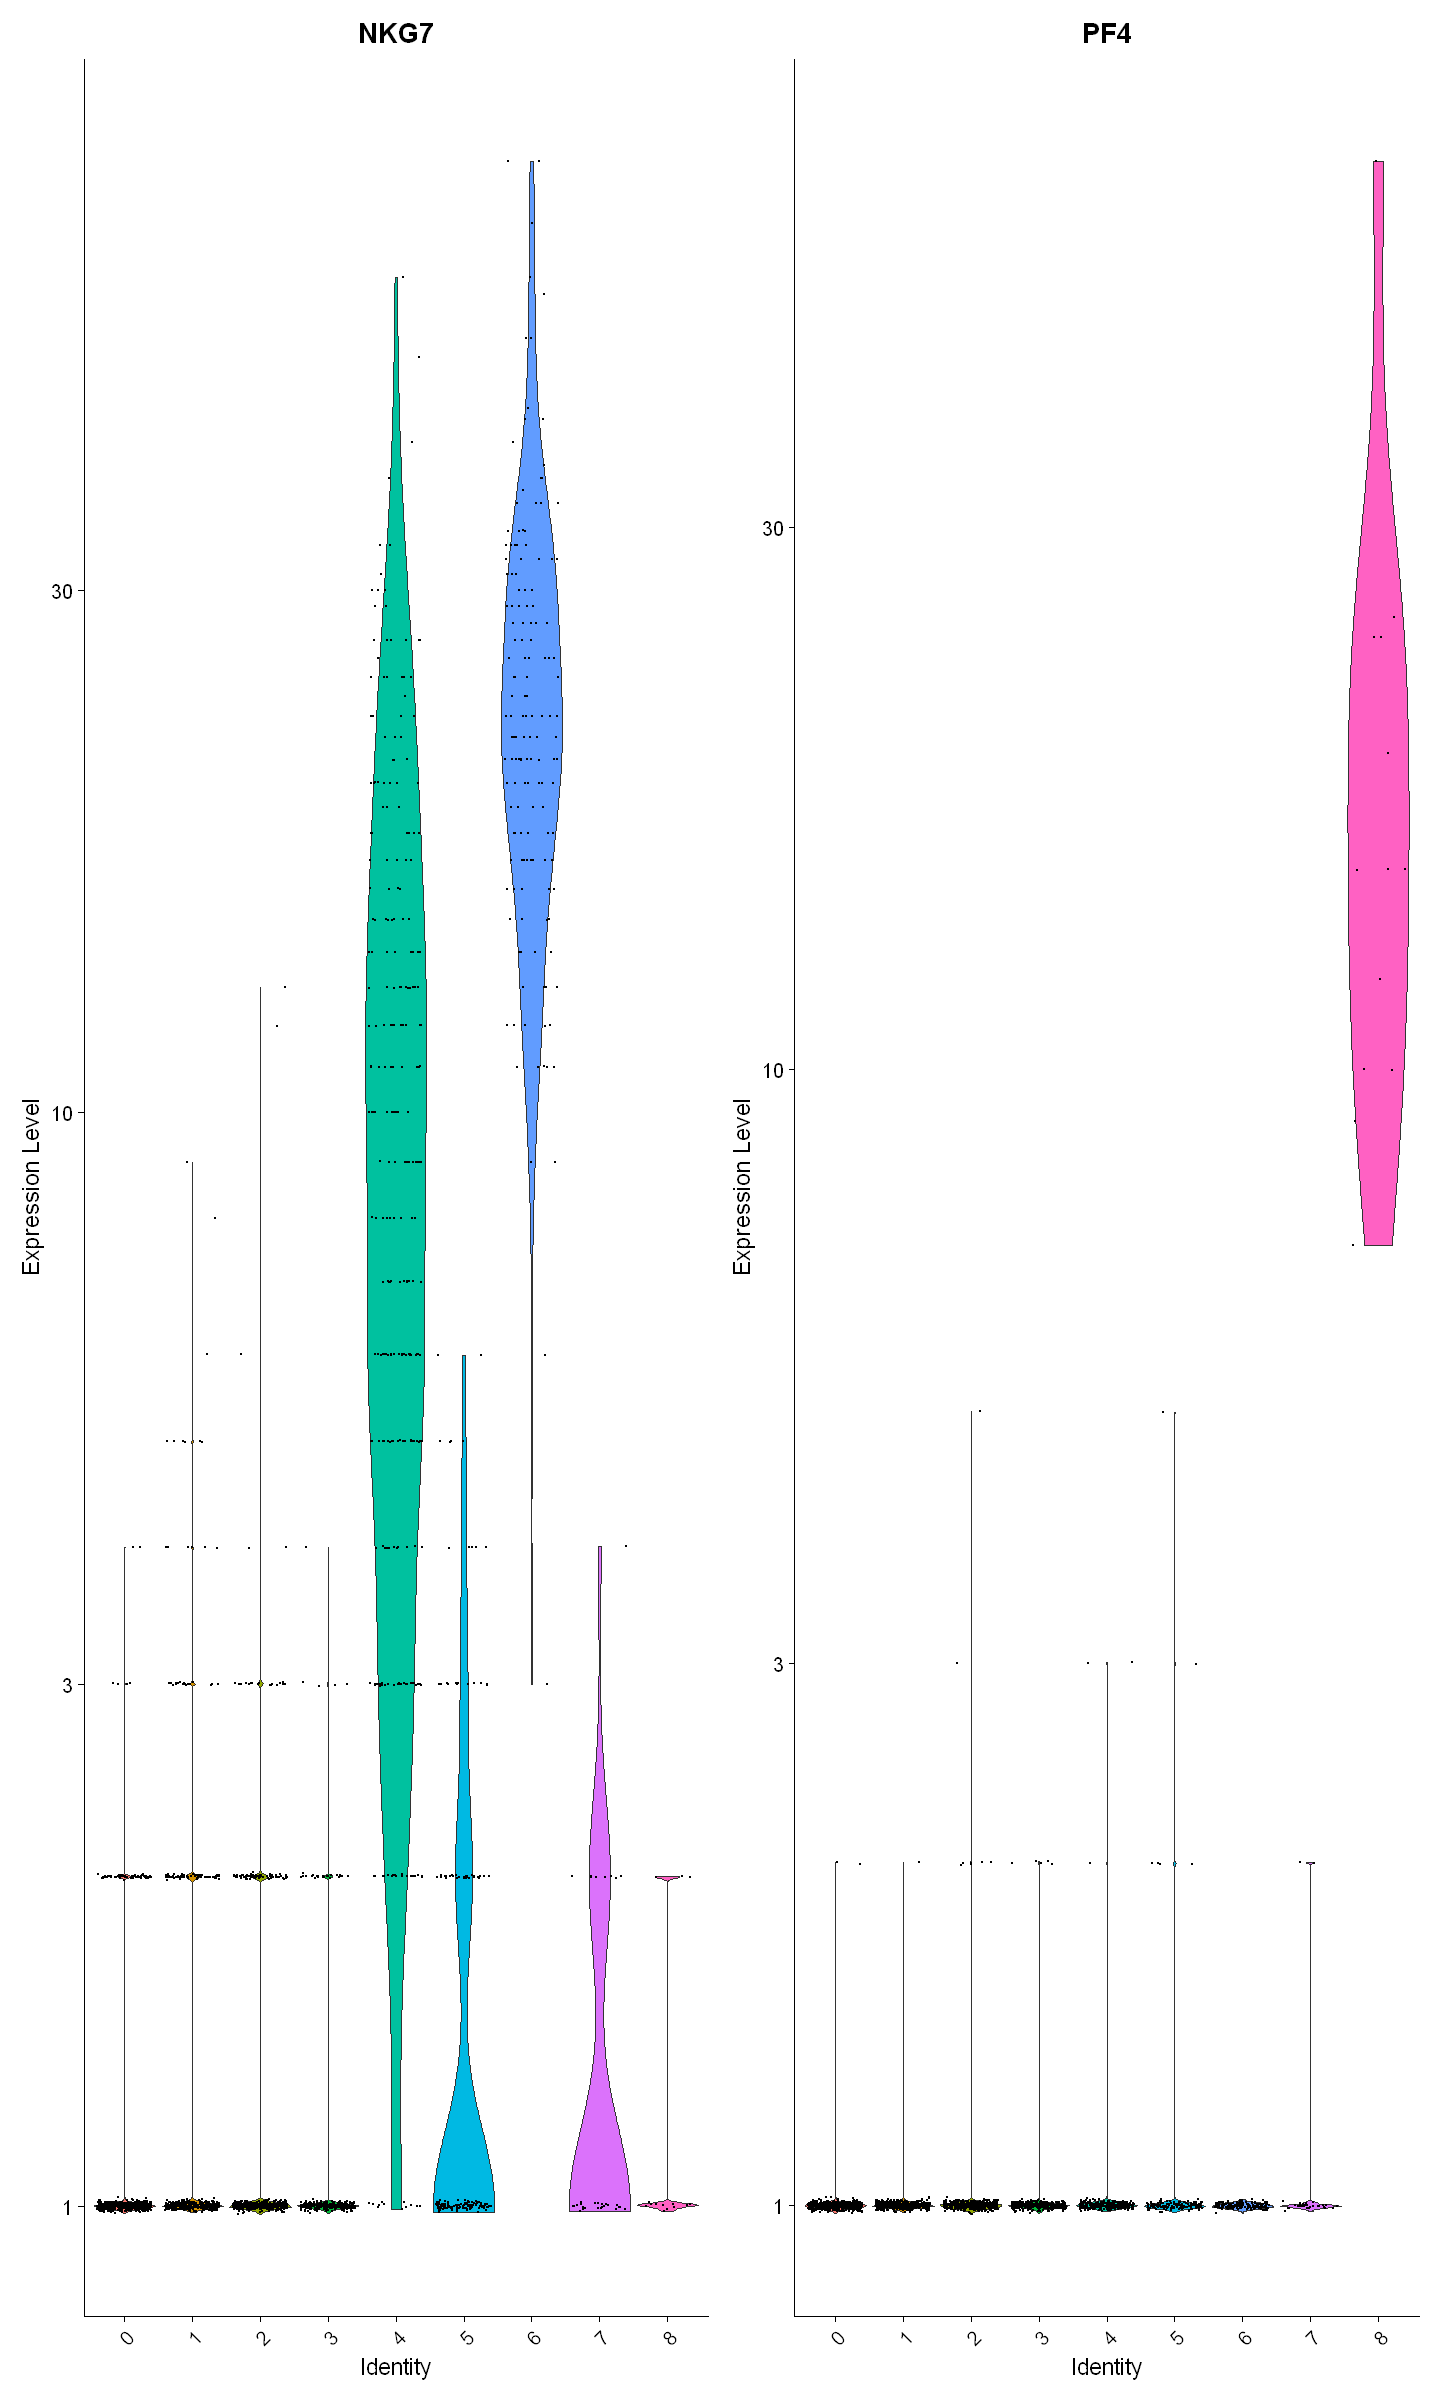

In [31]:
# you can plot raw counts as well
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

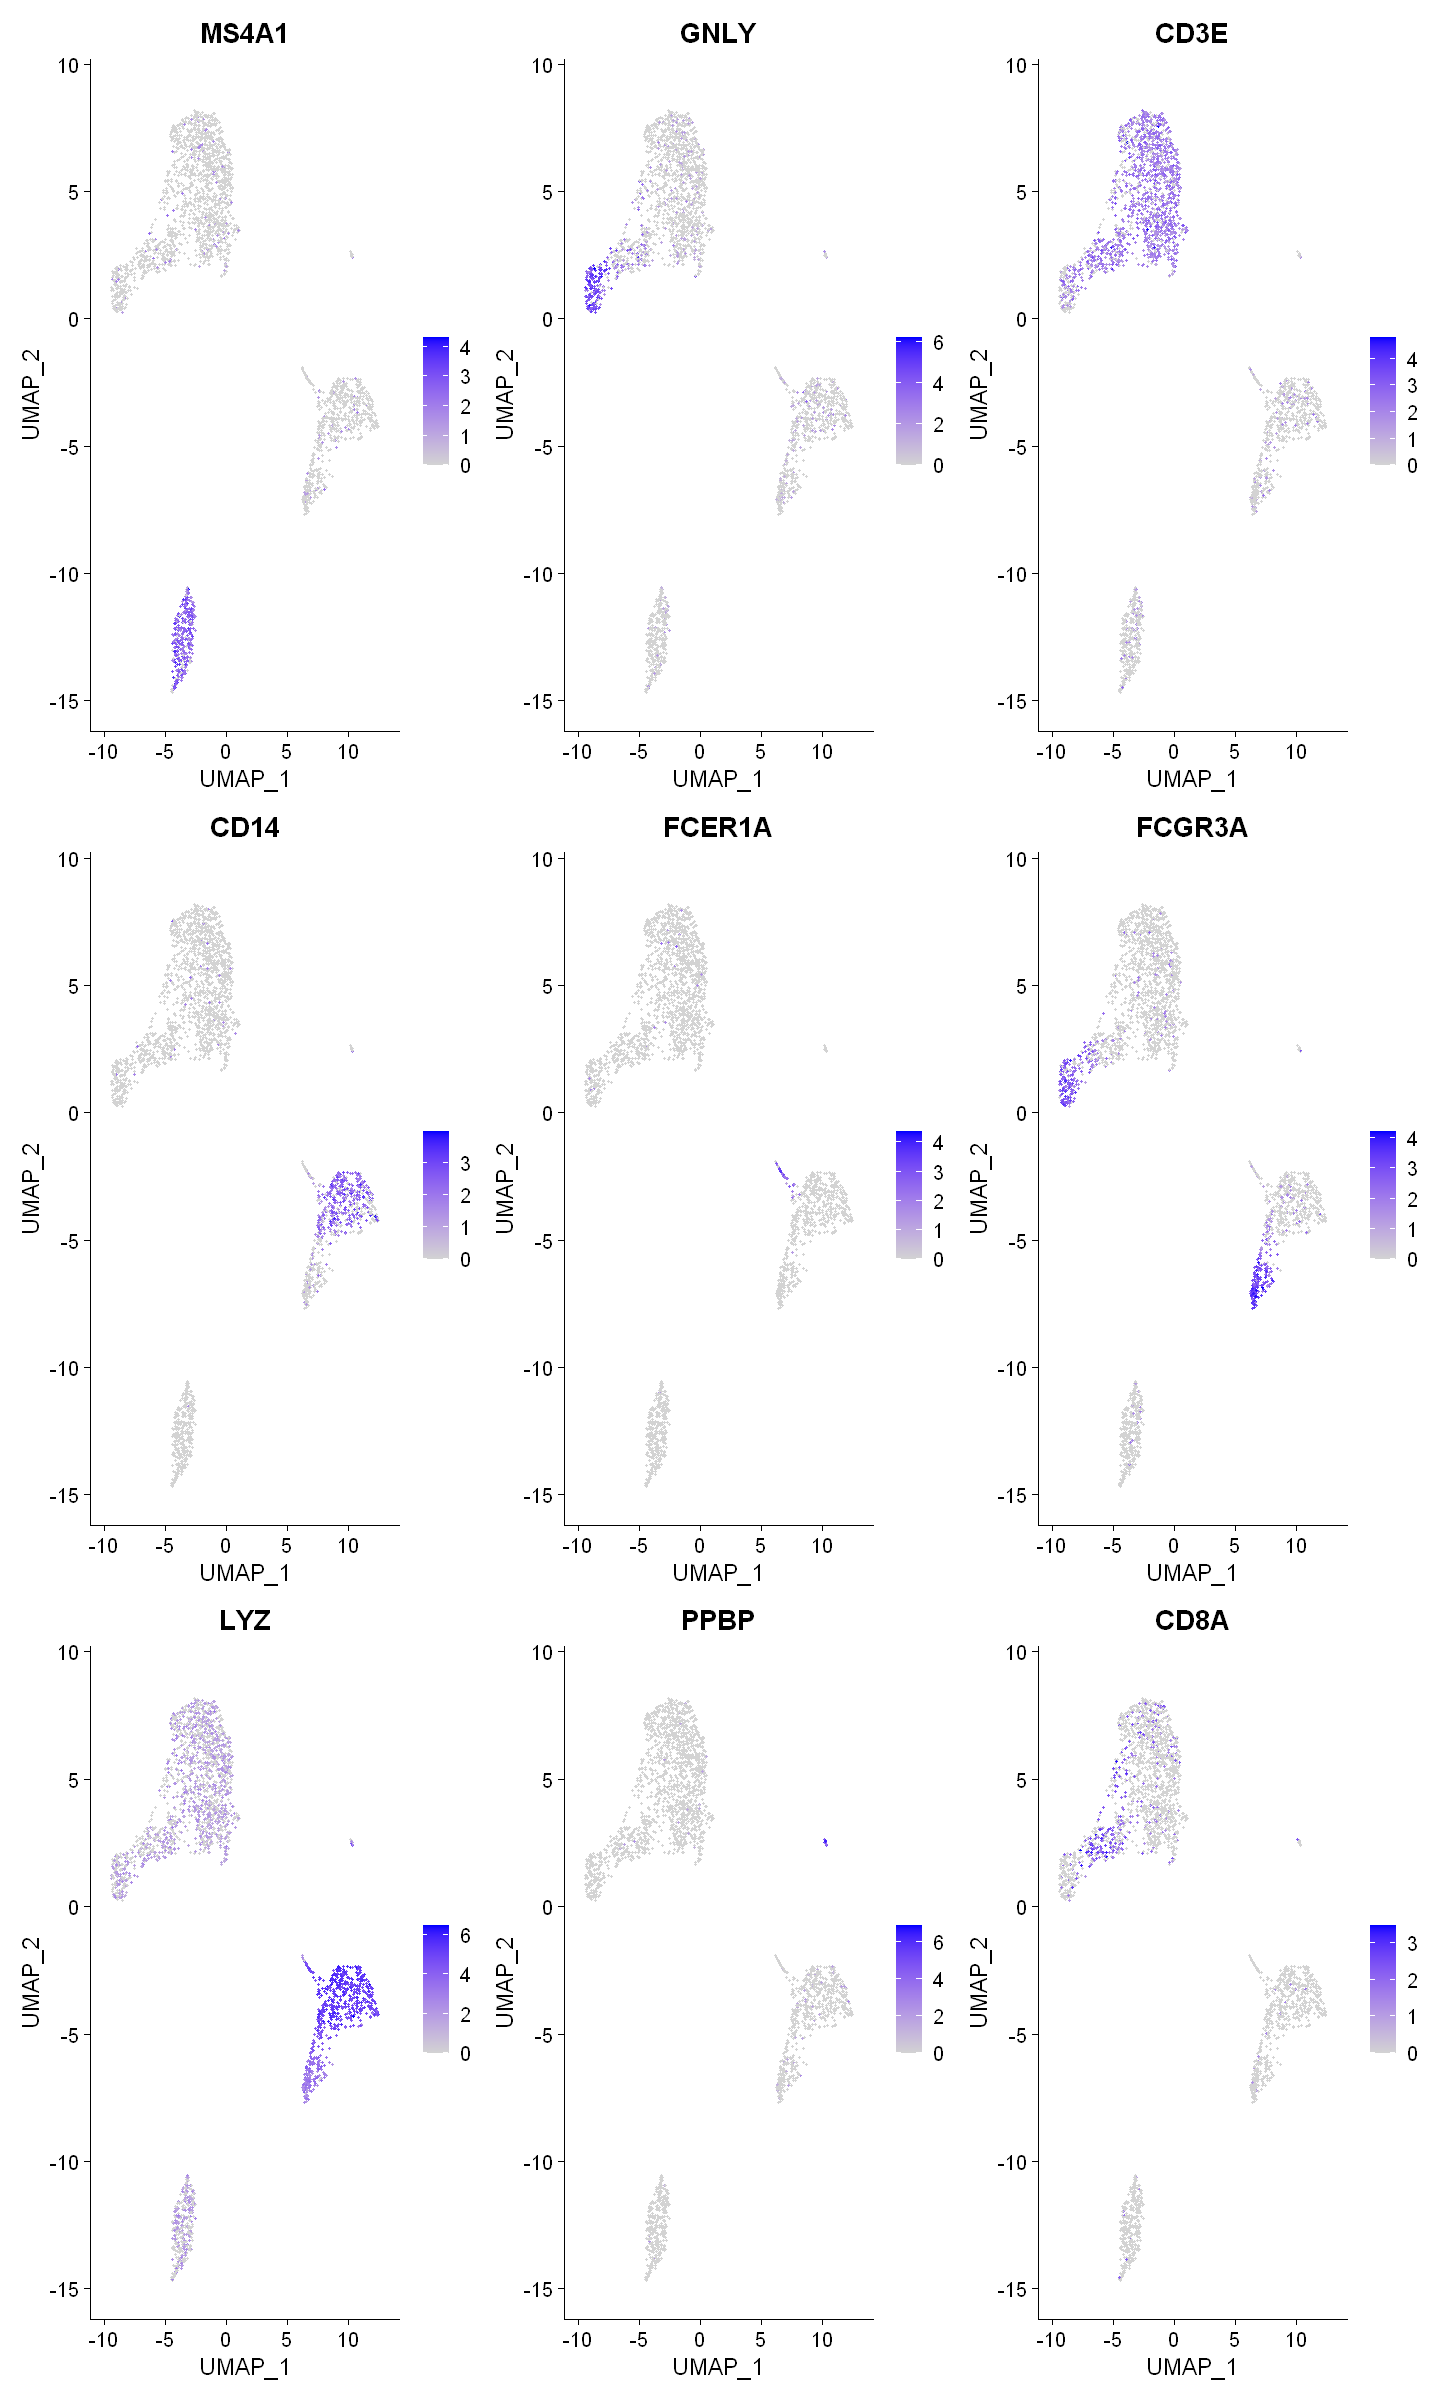

In [32]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",
    "CD8A"))
options(repr.plot.height = 13)

`DoHeatmap()` makes a heatmap for given cells and features.

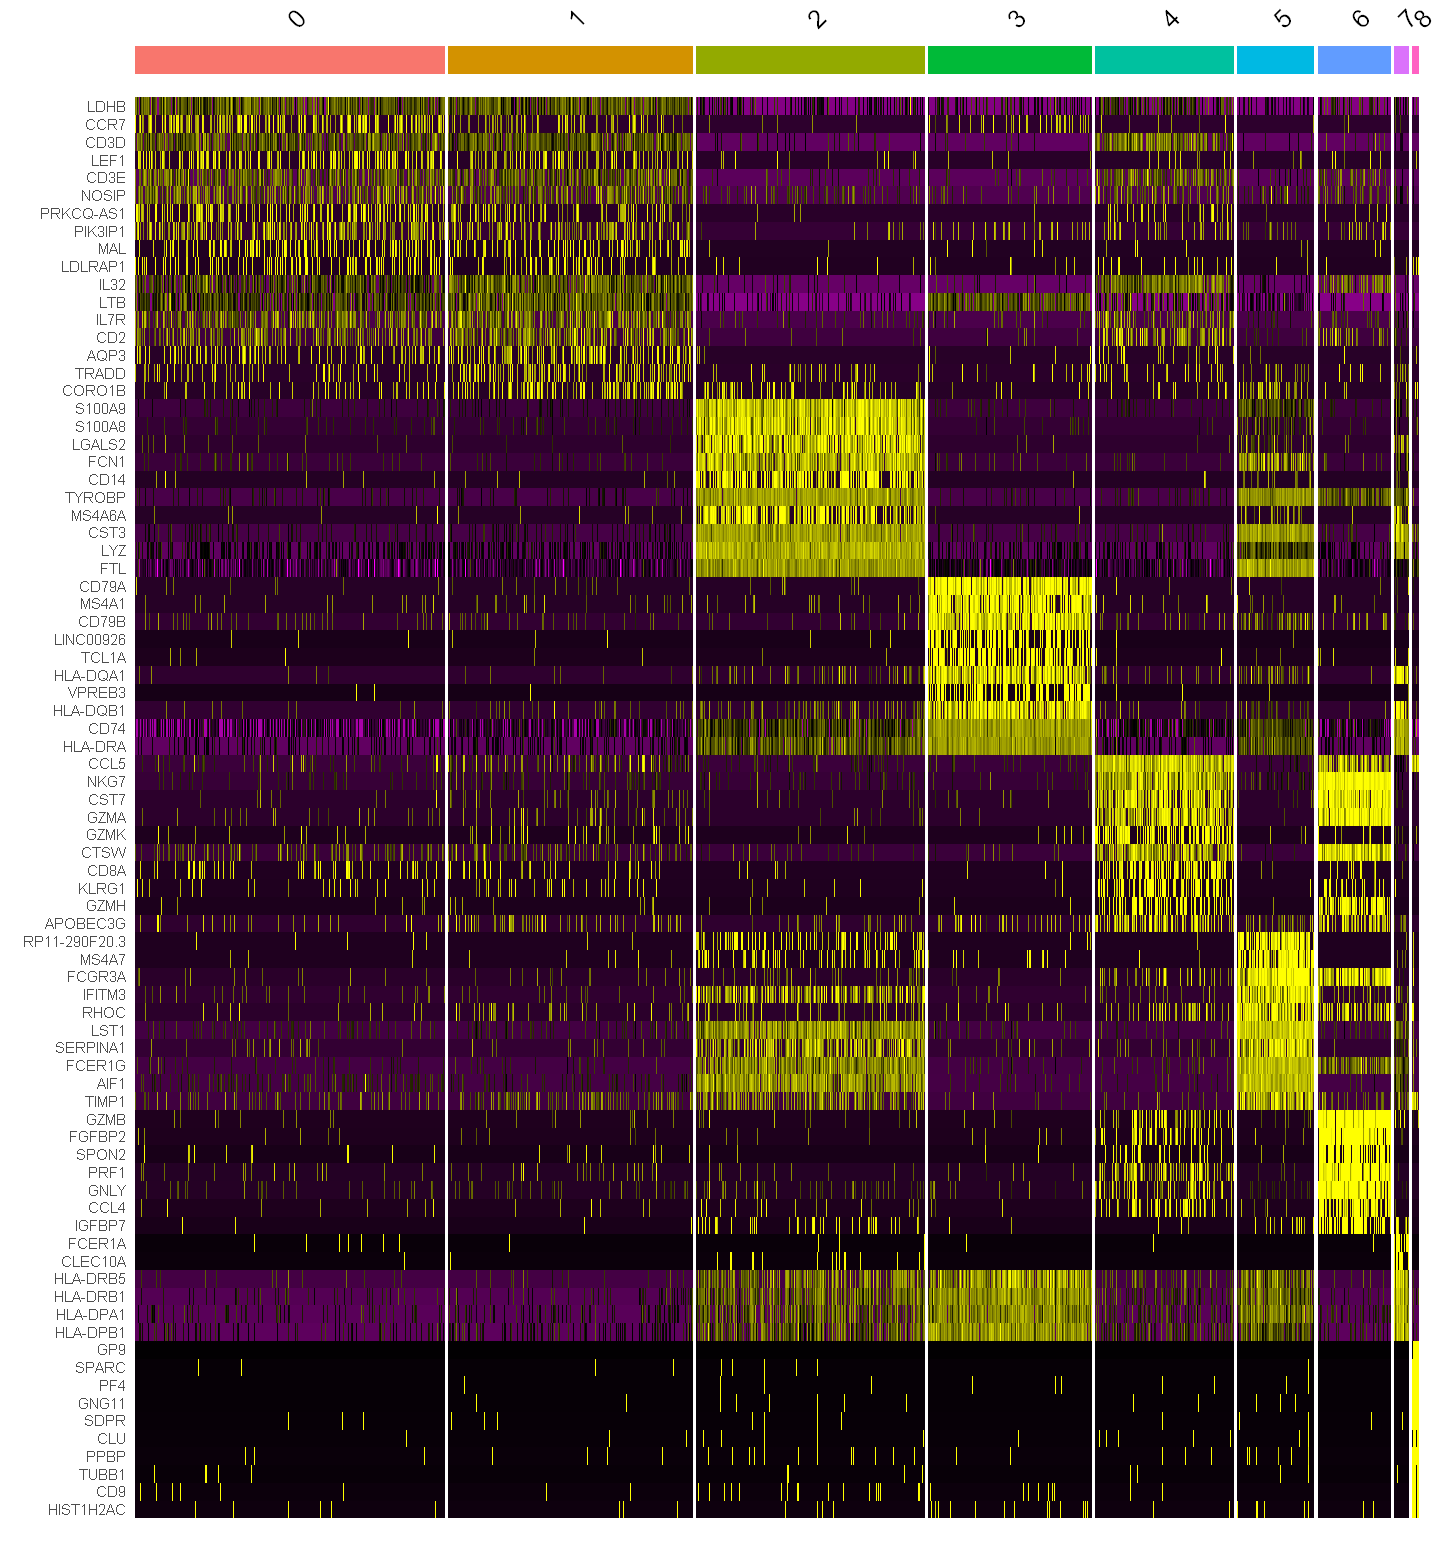

In [33]:
pbmc.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()
options(repr.plot.height = 11, repr.plot.width = 20)

## Assigning cell type identity to clusters

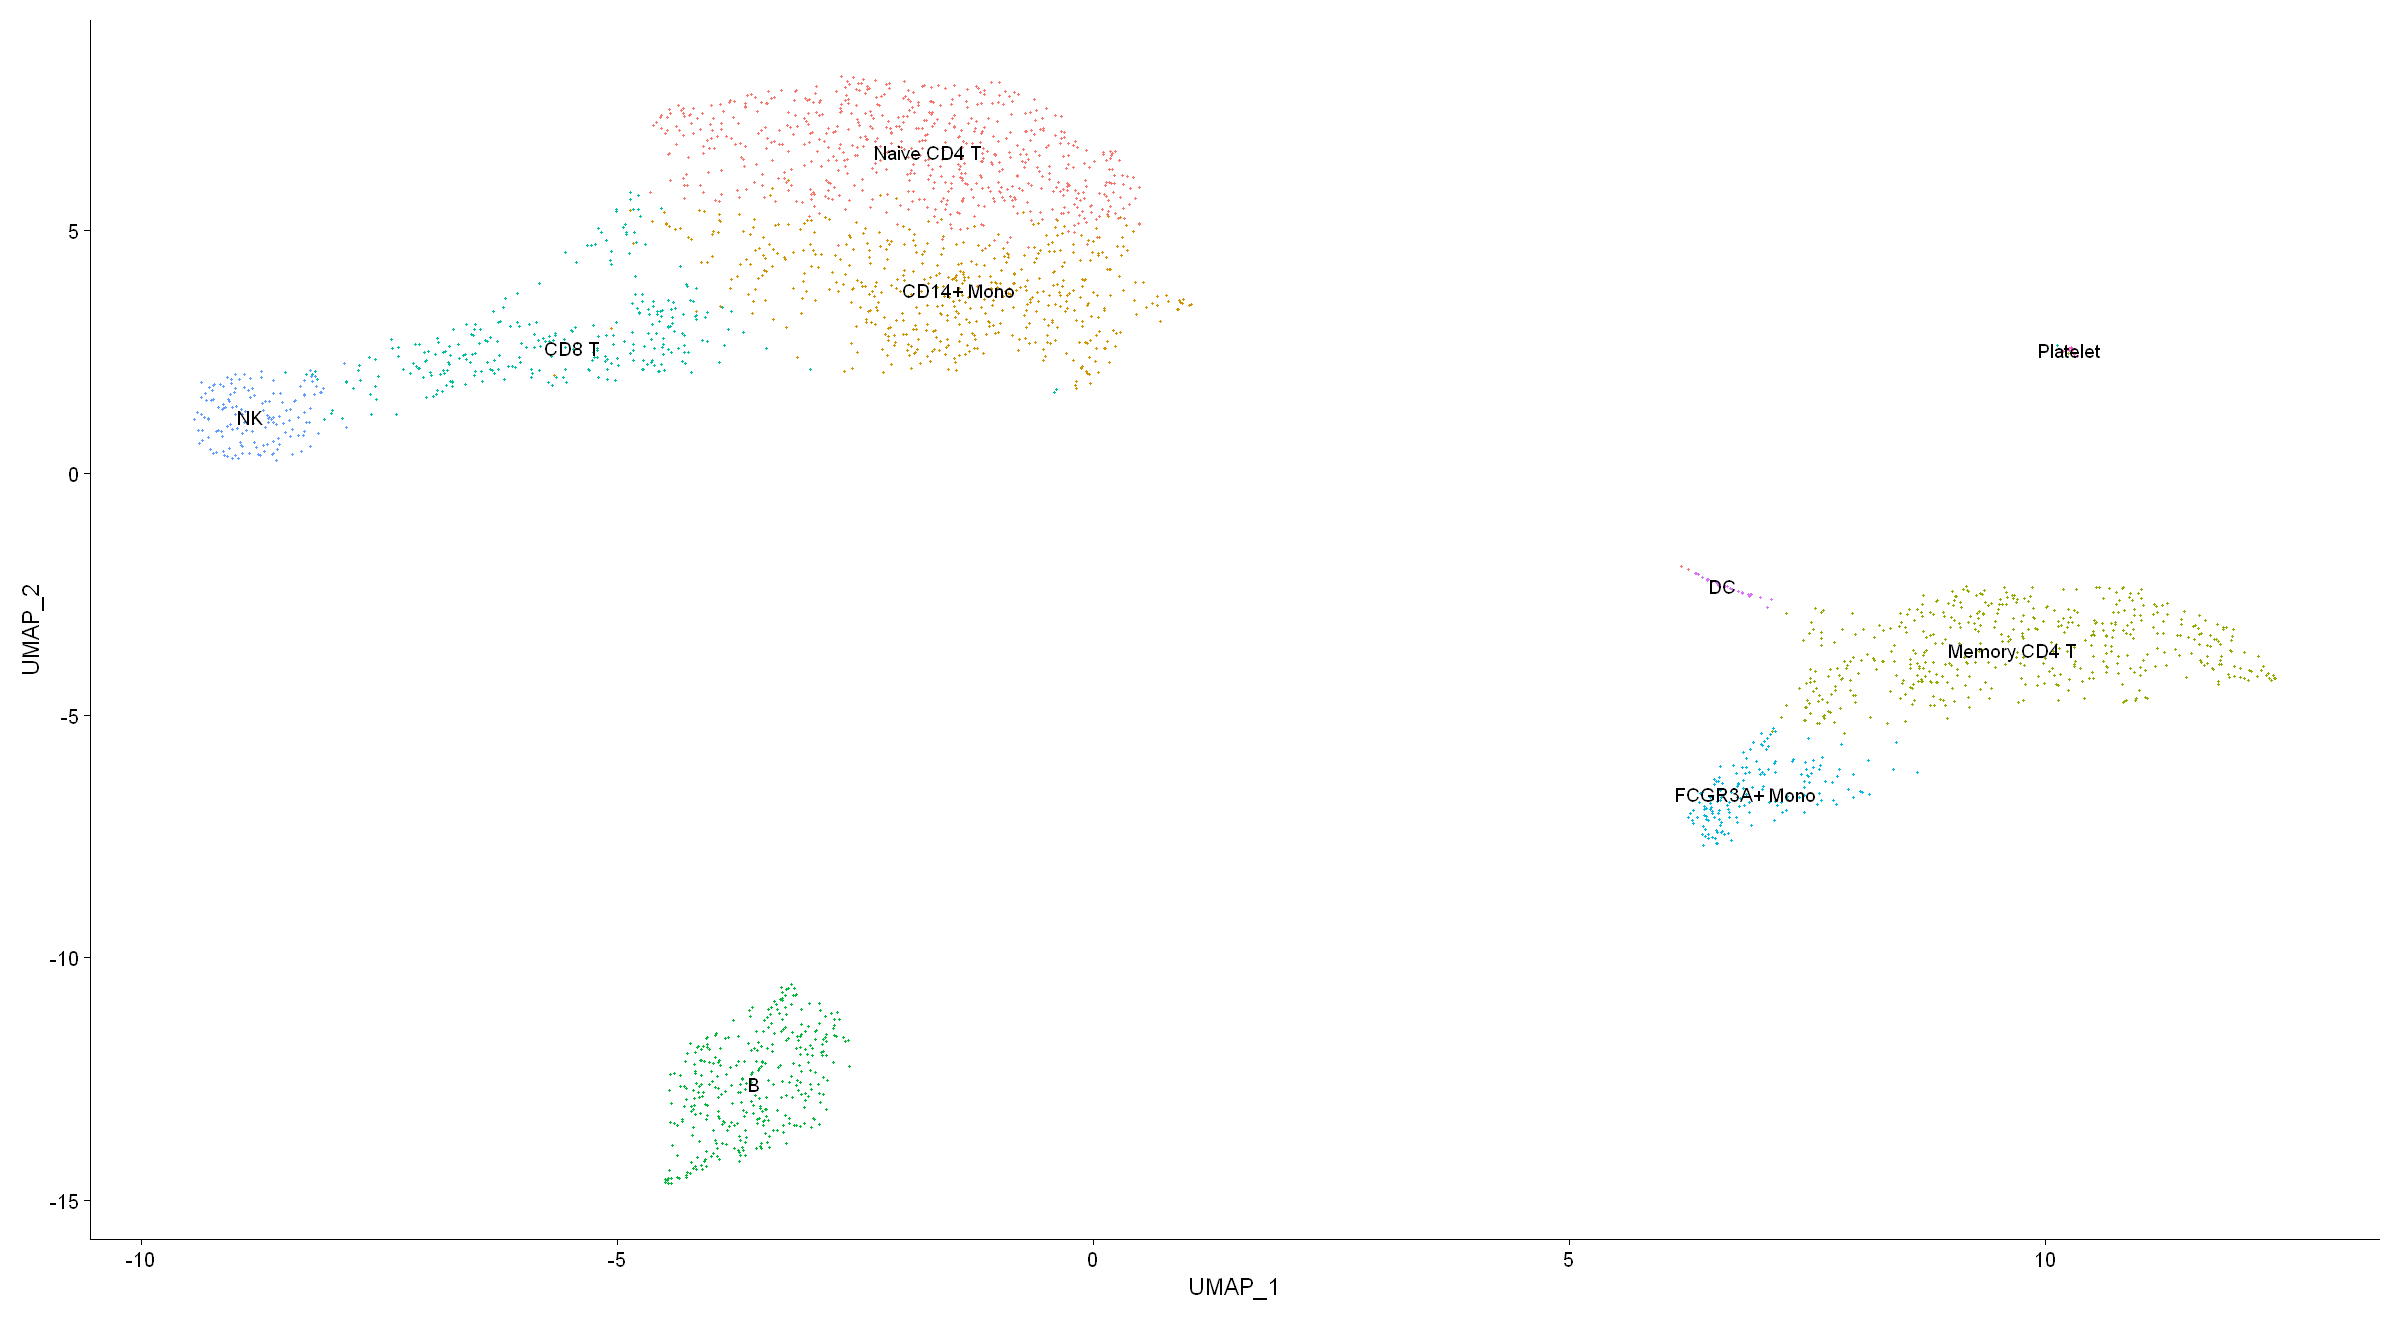

In [34]:
new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono",
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [35]:
#saveRDS(pbmc, file = "../output/pbmc3k_final.rds")

In [47]:
df <- as.data.frame(Idents(object = pbmc))
head(df)
write.csv(df, 'annotation.csv')

,Idents(object = pbmc)
,<fct>
AAACATACAACCAC-1,CD14+ Mono
AAACATTGAGCTAC-1,B
AAACATTGATCAGC-1,CD14+ Mono
AAACCGTGCTTCCG-1,Memory CD4 T
AAACCGTGTATGCG-1,NK
AAACGCACTGGTAC-1,CD14+ Mono


https://satijalab.org/seurat/articles/de_vignette.html 

In [36]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22000)

Matrix products: default

locale:
[1] LC_COLLATE=English_United Kingdom.1252 
[2] LC_CTYPE=English_United Kingdom.1252   
[3] LC_MONETARY=English_United Kingdom.1252
[4] LC_NUMERIC=C                           
[5] LC_TIME=English_United Kingdom.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] patchwork_1.1.2    sp_1.5-0           SeuratObject_4.1.2 Seurat_4.2.0      
[5] dplyr_1.0.10      

loaded via a namespace (and not attached):
  [1] Rtsne_0.16            colorspace_2.0-3      deldir_1.0-6         
  [4] ellipsis_0.3.2        ggridges_0.5.4        IRdisplay_1.1        
  [7] base64enc_0.1-3       spatstat.data_2.2-0   farver_2.1.1         
 [10] leiden_0.4.3          listenv_0.8.0         ggrepel_0.9.1        
 [13] fansi_1.0.3           codetools_0.2-18      splines_4.1.3       